In this file, the LEAR (Lagged Error Auto-Regressive) model will be applied to forecast the price based on historical price data. This serves as a benchmark model to evaluate the performance of other more complex forecasting methods. The LEAR model will use the historical data to predict future prices and assess its effectiveness in capturing trends and fluctuations in the pricing data.

In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from functions import plot_comparison, evaluate_model

In [2]:
df = pd.read_csv('../../Data/zra_sgp_dam.csv')

# Convert the 'Date' column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])
# Set the Date column as index
df.set_index('Date', inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: '../../Data/zra_sgp_dam.csv'

In [ ]:
# Generate lag features
df['price_lag30d'] = df['Price (USD/MWh)'].shift(24*30)
df['price_lag30d'] = df['price_lag30d'].fillna(df['Price (USD/MWh)'])  # Fill with actual price for 30-day lag

df['price_lag60d'] = df['Price (USD/MWh)'].shift(24*60)
df['price_lag60d'] = df['price_lag60d'].fillna(df['Price (USD/MWh)'])  # Fill with actual price for 60-day lag

df['price_lag90d'] = df['Price (USD/MWh)'].shift(24*90)
df['price_lag90d'] = df['price_lag90d'].fillna(df['Price (USD/MWh)'])  # Fill with actual price for 90-day lag


In [ ]:
import numpy as np
def encode_cyclic(df, col, max_val):
    """"
    Time features like Hour, Month, day_of_week are cyclical, not linear. 
    Without encoding them properly, the model will misunderstand their relationships.
    """
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

def preprocess(df):
    df = df.copy()
    
    # Cyclic encode time features
    df = encode_cyclic(df, 'Hour', 24)
    df = encode_cyclic(df, 'Month', 12)
    df = encode_cyclic(df, 'day_of_week', 7)
    
    # Drop unused or problematic columns
    df = df.drop(columns=['Hour', 'Month', 'day_of_week'])  # Keep cyclic versions instead
    
    # Fill/clean if needed
    df = df.fillna(method='ffill').dropna()
    
    return df

def evaluate(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Directional accuracy (compare sign of changes)
    true_diff = np.diff(y_true)
    pred_diff = np.diff(y_pred)
    dae = np.mean(np.sign(true_diff) == np.sign(pred_diff))

    lower_pct = np.mean(y_pred < y_true) * 100
    return mae, rmse, r2, dae, lower_pct

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Preprocess (make sure 'Date' becomes index)
df_clean = preprocess(df)

# Define target
target_col = 'Price (USD/MWh)'
features = df_clean.drop(columns=[target_col])
target = df_clean[target_col]

# Columns by type
minmax_cols = ['Tati- normalised output', 'E_Grid (Mw)', 'Revenues (USD)', 
               'Flow_chavuma', 'Level_kariba', 'Flow_nana']
standard_cols = ['Volatility_1 Day', 'Volatility_3 Days', 'Volatility_7 Days', 'Volatility_30 Days',
                 'roc_49h', 'momentum_49h']
no_scaling_cols = ['Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos',
                   'day_of_week_sin', 'day_of_week_cos']

# Initialize scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
scaler_y = MinMaxScaler()

# Copy clean DataFrame
df_scaled = df_clean.copy()

# Apply scalers to appropriate columns
df_scaled[minmax_cols] = minmax_scaler.fit_transform(df_clean[minmax_cols])
df_scaled[standard_cols] = standard_scaler.fit_transform(df_clean[standard_cols])

# Target scaling (fit only on the column, keep shape)
df_scaled["target_scaled"] = scaler_y.fit_transform(df_clean[[target_col]])

# Optionally retain unscaled target for reference
df_scaled[target_col] = target


/var/folders/t_/0kjgy0zn0k10thg9kn806w140000gn/T/ipykernel_48553/424768561.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').dropna()


In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# --- Preprocessing (assume preprocess function is defined) ---
df_clean = preprocess(df)  # make sure 'Date' is index in this step

# Create lag features upfront (assume hourly data, 24 per day)
lags_days = [7, 30, 60, 90]
for lag in lags_days:
    col_name = f'price_lag{lag}d'
    df_clean[col_name] = df_clean['Price (USD/MWh)'].shift(24*lag)
    df_clean[col_name].fillna(df_clean['Price (USD/MWh)'], inplace=True)  # fill initial NAs with current price


/var/folders/t_/0kjgy0zn0k10thg9kn806w140000gn/T/ipykernel_48553/424768561.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').dropna()
/var/folders/t_/0kjgy0zn0k10thg9kn806w140000gn/T/ipykernel_48553/2773569774.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col_name].fillna(df_clean['Price (USD/MWh)'], inplace=True)  # fill initial NAs with current price


In [ ]:
# Define lag columns as list
lag_cols = [f'price_lag{lag}d' for lag in lags_days]

# Define base features = all columns except lag columns, target, and target_scaled
exclude_cols = lag_cols + [target_col, 'target_scaled']
base_feature_cols = [col for col in df_scaled.columns if col not in exclude_cols]

results = []
lags = []

# Loop over lookbacks
for lookback in lags_days:
    # print(f"\n--- Lookback: {lookback} days ---")
    lags.append(lookback)
    current_lag = f'price_lag{lookback}d'
    if current_lag not in df_scaled.columns:
        print(f"Missing lag column: {current_lag}")
        continue
    
    # Features = base features + current lag only
    feature_cols =  [current_lag] + base_feature_cols
    
    X = df_scaled[feature_cols]
    y = df_scaled['target_scaled']

    # Train-validation-test split (70-15-15), no shuffle
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
    
    # Initialize Lasso
    model = Lasso(alpha=0.1)
    
    # Train model and time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Predictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Evaluate on validation
    val_mae, val_rmse, val_r2, val_dae, val_lower = evaluate(y_val, y_val_pred)
    # Evaluate on test
    test_mae, test_rmse, test_r2, test_dae, test_lower = evaluate(y_test, y_test_pred)
    
    # Save results
    results.append({
        'Lookback (days)': lookback,
        'Training Time (s)': round(training_time, 4),
        
        'Val MAE': round(val_mae, 4),
        'Val RMSE': round(val_rmse, 4),
        'Val R2': round(val_r2, 4),
        'Val DAE': round(val_dae, 4),
        'Val Lower Predictions %': round(val_lower, 2),
        
        'Test MAE': round(test_mae, 4),
        'Test RMSE': round(test_rmse, 4),
        'Test R2': round(test_r2, 4),
        'Test DAE': round(test_dae, 4),
        'Test Lower Predictions %': round(test_lower, 2),
    })
    results_df = pd.DataFrame(results)



In [ ]:
    
# Summary of results
results_df = pd.DataFrame(results)
# Print LaTeX table rows with ampersands
# Print LaTeX table rows for Validation results
# Save results dictionary
results.append({
    'Lookback (days)': lookback,
    'Training Time (s)': round(training_time, 4),

    'Val MAE': round(val_mae, 4),
    'Val RMSE': round(val_rmse, 4),
    'Val R2': round(val_r2, 4),
    'Val DAE': round(val_dae, 4),
    'Val Lower Predictions %': round(val_lower, 2),

    'Test MAE': round(test_mae, 4),
    'Test RMSE': round(test_rmse, 4),
    'Test R2': round(test_r2, 4),
    'Test DAE': round(test_dae, 4),
    'Test Lower Predictions %': round(test_lower, 2),
})


print("\nSummary Results:")
print(results_df)

KeyError: 'Metric'

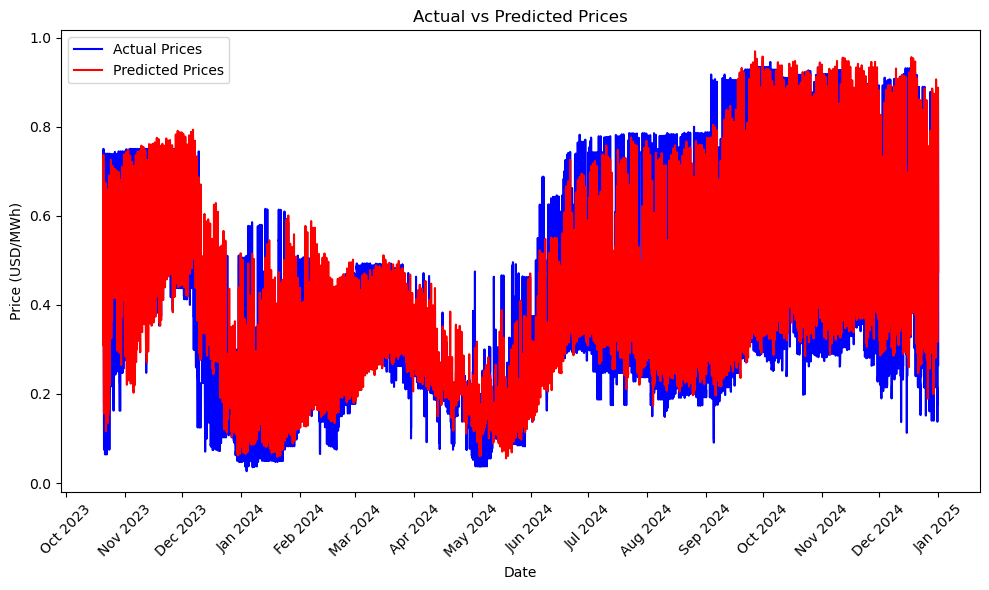

In [9]:
plot_comparison(y_test,y_test_pred,df, 'month')

In [11]:
evaluate_model(y_val, y_val_pred, y_test, y_test_pred, X_val, X_test, plot_fig=None)

,Metric,MAE,RMSE,DAE
0,Validation Set,0.067643,0.104585,0.048943
1,Test Set,0.075313,0.108601,0.050985
